In [1]:
# +
from dataset.semi import SemiDataset
from model.semseg.deeplabv2 import DeepLabV2
from model.semseg.deeplabv3plus import DeepLabV3Plus
from model.semseg.pspnet import PSPNet
from utils.utils import count_params, meanIOU, color_map, DiceCoefficient

from utils.loss_file import save_loss
# -

import argparse
from copy import deepcopy
import numpy as np
import os
import json
from PIL import Image
import torch
from torch.nn import CrossEntropyLoss, DataParallel, functional as F
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss, DataParallel, functional as F
import albumentations as albu

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
semi_setting = 'kidney/1-3'
save_path = f'outdir/models/{semi_setting}'
pseudo_mask_path = f'outdir/pseudo_masks/{semi_setting}'
labeled_id_path = f'dataset/splits/{semi_setting}/train.txt'
unlabeled_id_path = f'dataset/splits/{semi_setting}/unlabeled.txt'
reliable_id_path = f'outdir/reliable_ids/{semi_setting}'

# data_root = '/home/S312112021/dataset/0_data_dataset_voc_950'
data_root = 'data/0_data_dataset_voc_950'
batch_size = 4
crop_size = 224
plus = True
dataset ='kidney'


if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(pseudo_mask_path):
    os.makedirs(pseudo_mask_path)
if plus and reliable_id_path is None:
    exit('Please specify reliable-id-path in ST++.')

In [ ]:
def get_training_augmentation():

    train_transform = [
        albu.HorizontalFlip(p=0.5),
        # 2023.2.19 不要 scale，scale_limit 由 0.5 改為 0
        albu.ShiftScaleRotate(scale_limit=0, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=704, min_width=704, always_apply=True, border_mode=0),# padding 的概念
        albu.RandomCrop(height=704, width=704, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),# 將圖片投影到新的平面

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

"""Add paddings to make image shape divisible by 32"""
def get_validation_augmentation():
    test_transform = [
#         albu.PadIfNeeded(704, 704)
        # 2023.2.18 added
        albu.PadIfNeeded(min_height=704, min_width=704, always_apply=True, border_mode=0),
        albu.RandomCrop(height=704, width=704, always_apply=True),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [3]:
MODE = 'semi_train'

trainset = SemiDataset(dataset, data_root, MODE, crop_size,
                        labeled_id_path, unlabeled_id_path, pseudo_mask_path)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True,
                            pin_memory=True, num_workers=16, drop_last=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:562: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
import numpy as np
from matplotlib import pyplot as plt

trainset = SemiDataset(dataset, data_root, 'semi_train', crop_size,
                        labeled_id_path, unlabeled_id_path, pseudo_mask_path)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True,
                            pin_memory=True, num_workers=16, drop_last=True)

for i, (img, mask) in enumerate(trainloader):
    print('img.shape: ', img.shape)    
    print('mask.shape: ', mask.shape)

    print('mask min value: ', mask.min().item())
    print('mask max value: ', mask.max().item())
    break



MODE = 'train'
trainset = SemiDataset(dataset, data_root, MODE, crop_size, labeled_id_path)
trainset.ids = 2 * trainset.ids if len(trainset.ids) < 200 else trainset.ids
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         pin_memory=True, num_workers=16, drop_last=True)
for i, (img, mask) in enumerate(trainloader):
    print('img.shape: ', img.shape)    
    print('mask.shape: ', mask.shape)

    print('mask min value: ', mask.min().item())
    print('mask max value: ', mask.max().item())  
    break


img.shape:  torch.Size([4, 3, 224, 224])
mask.shape:  torch.Size([4, 224, 224])
mask min value:  0
mask max value:  1
img.shape:  torch.Size([4, 3, 224, 224])
mask.shape:  torch.Size([4, 224, 224])
mask min value:  0
mask max value:  1


In [5]:
MODE = 'train'
# MODE = 'semi_train'
trainset = SemiDataset(dataset, data_root, MODE, crop_size, labeled_id_path)

# reliable_ids_path = 'outdir/reliable_ids/kidney/1-3/reliable_ids.txt'
# trainset = SemiDataset(dataset, data_root, MODE, crop_size, 'dataset/splits/kidney/1-3/labeled.txt', 
#                        reliable_ids_path,
#                        'outdir/pseudo_masks/kidney/1-3')
trainset = SemiDataset(dataset, data_root, MODE, crop_size, labeled_id_path)

trainset.ids = 2 * trainset.ids if len(trainset.ids) < 200 else trainset.ids
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         pin_memory=True, num_workers=16, drop_last=True)

In [6]:
def init_basic_elems():
    model_zoo = {'deeplabv3plus': DeepLabV3Plus, 'pspnet': PSPNet, 'deeplabv2': DeepLabV2}
    model = model_zoo['deeplabv3plus']('resnet18', 2 if dataset == 'kidney' else 19)

    head_lr_multiple = 10.0

    optimizer = SGD([{'params': model.backbone.parameters(), 'lr': 0.001},
                     {'params': [param for name, param in model.named_parameters()
                                 if 'backbone' not in name],
                      'lr': 0.001 * head_lr_multiple}],
                    lr=0.001, momentum=0.9, weight_decay=1e-4)

    model = DataParallel(model).cuda()

    return model, optimizer

In [7]:
model, optimizer = init_basic_elems()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, pred, targets, smooth=1):
        target_one_hot = F.one_hot(targets, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        target_one_hot = target_one_hot[:, 1:, :, :]
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        pred = pred[:, 1:, :, :]  # shape: (16, C-1, 224, 224), e.g. (16, 3, 224, 224) -> (16, 2, 224, 224)
        pred = F.sigmoid(pred)
        
        #flatten label and prediction tensors
        pred_flat = pred.contiguous().view(-1)
        target_flat = target_one_hot.contiguous().view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice

In [9]:
criterion = DiceLoss()

In [10]:
for img, mask in trainloader:
    img, mask = img.to(device), mask.to(device)
    pred = model(img)  
    break

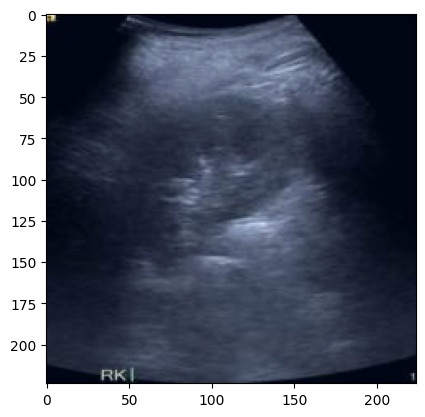

In [11]:
# 假設 img 是 PyTorch 張量，其形狀為 (3, 224, 224)
img = img[0].permute(1, 2, 0)  # 將形狀轉換為 (224, 224, 3)

# 將張量移動到 CPU 並轉換為 NumPy 陣列
img = img.cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)  # 在圖表中繪製圖片
plt.show()

In [12]:
print('img shape: ', img.shape)
print('mask shape: ', mask.shape)
print('pred shape: ', pred.shape)

# 檢查 masks 的最小值和最大值
print('mask min value: ', mask.min().item())
print('mask max value: ', mask.max().item())

print('pred min value: ', pred.min().item())
print('pred max value: ', pred.max().item())

img shape:  (224, 224, 3)
mask shape:  torch.Size([4, 224, 224])
pred shape:  torch.Size([4, 2, 224, 224])
mask min value:  0
mask max value:  1
pred min value:  -1.9443672895431519
pred max value:  1.8938207626342773


In [13]:
loss = criterion(pred, mask)

print('Loss: ', loss.item())

Loss:  0.7838826775550842


In [14]:
def pltPred(input):
    # 可視化 pred_classes 的第一個樣本
    one_pred = input[0].detach().cpu().numpy()

    # 獲取兩個 channel
    pred_class_sample1 = one_pred[0]
    pred_class_sample2 = one_pred[1]

    # 創建一個圖形窗口，包含兩個子圖
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # 顯示第一個 channel
    axes[0].imshow(pred_class_sample1, cmap='viridis')
    axes[0].set_title('Predicted Classes - Channel 1')

    # 顯示第二個 channel
    axes[1].imshow(pred_class_sample2, cmap='viridis')
    axes[1].set_title('Predicted Classes - Channel 2')

    plt.show()

In [15]:
one_mask = F.one_hot(mask, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
one_pseudo = F.one_hot(mask, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

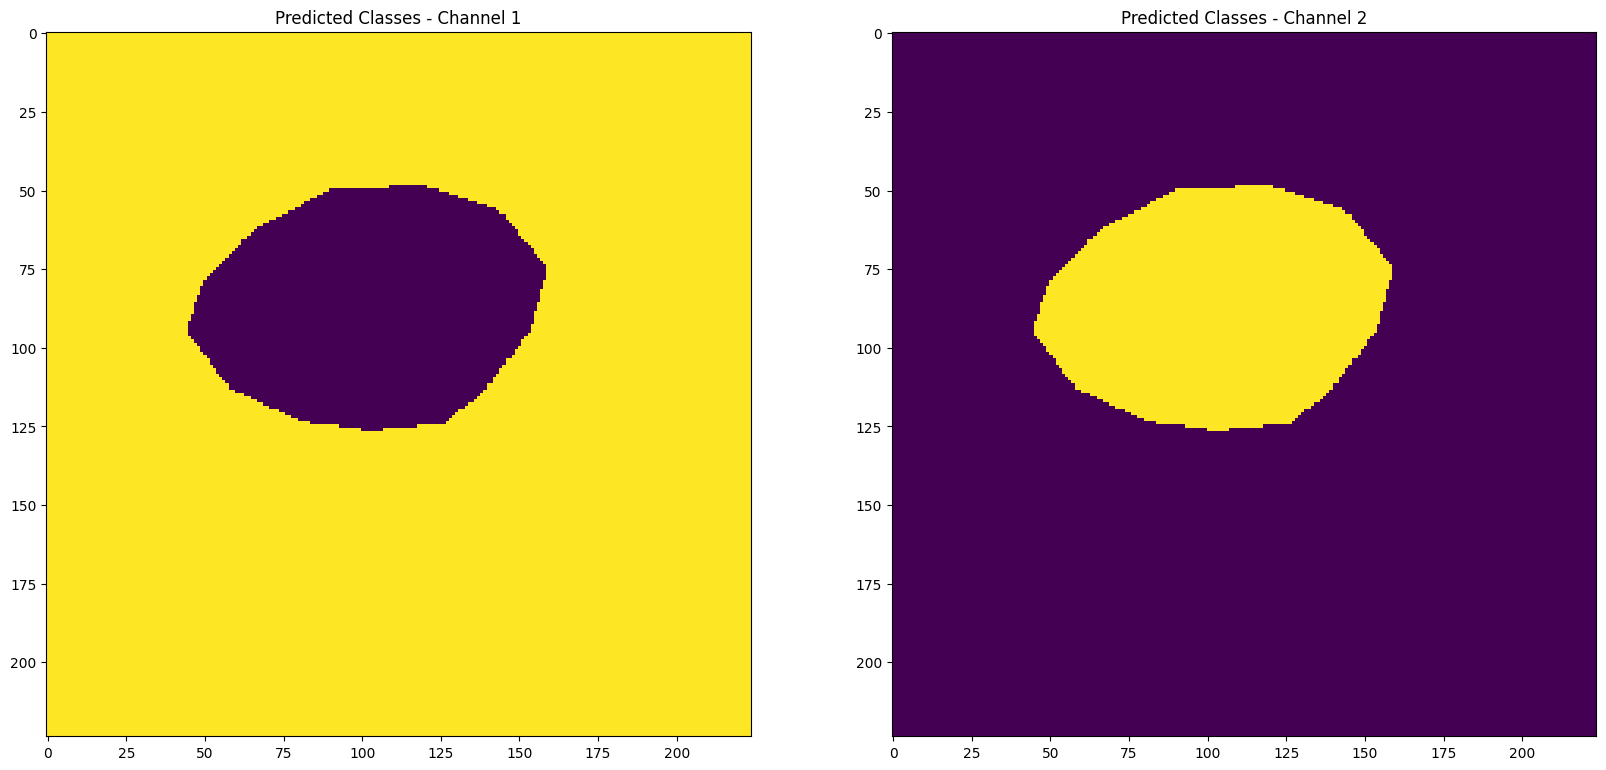

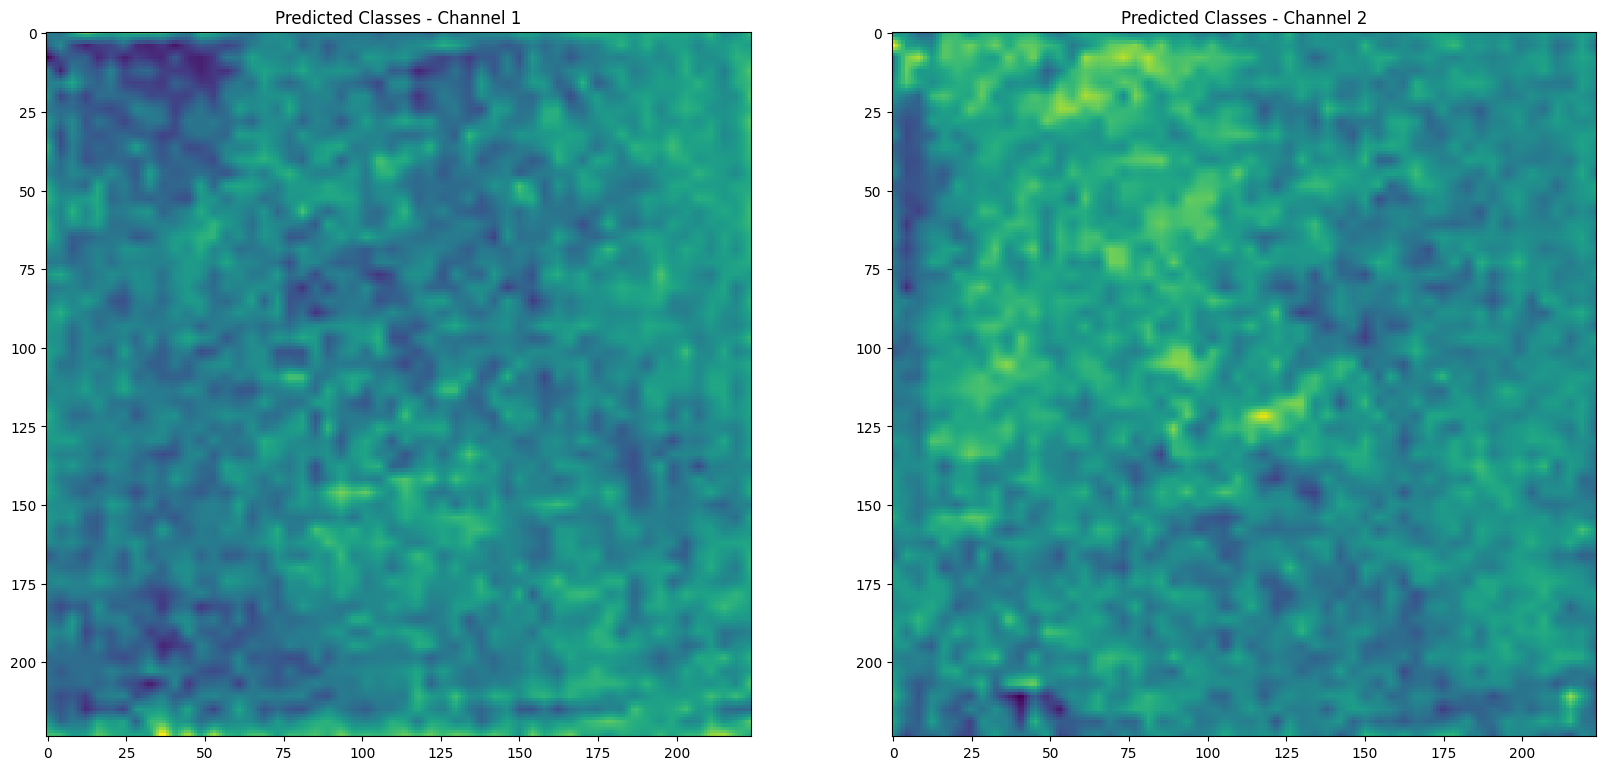

In [16]:
pltPred(one_mask)
pltPred(pred)